## Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load metadata

In [2]:
import pandas as pd
from pathlib import Path


# remove duplicate entries from csv data
nonships_meta = pd.read_csv(Path("/content/drive/MyDrive/OTH/space-eye/dataset/nonshipsAIS_2017_Zone17.csv"))
nonships_meta = nonships_meta.drop_duplicates(subset="newindex")
nonships_meta = nonships_meta.set_index('newindex', verify_integrity=True)

ships_meta = pd.read_csv(Path("/content/drive/MyDrive/OTH/space-eye/dataset/shipsAIS_2017_Zone17.csv"))
ships_meta = ships_meta.drop_duplicates(subset="newindex")
ships_meta = ships_meta.set_index('newindex', verify_integrity=True)

In [3]:
from pathlib import Path

data_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped")

In [4]:
nonships_count = len(list(data_dir.glob('nonships/*')))
ships_count = len(list(data_dir.glob('ships/*')))

ships_count, nonships_count

(872, 880)

## Load Data

In [5]:
# import os
# import rasterio
# import matplotlib.pyplot as plt
# import numpy as np

from tensorflow.keras.preprocessing import image
from pathlib import Path

train_data_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/jpg600")
img_height = 400
img_width = 400
batch_size = 32

data_gen = image.ImageDataGenerator(rescale=1./255.,
                                    rotation_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.2)

train_gen = data_gen.flow_from_directory(train_data_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                subset='training')
                                         
validation_gen = data_gen.flow_from_directory(
                                  train_data_dir,
                                  target_size=(img_height, img_width),
                                  batch_size=batch_size,
                                  class_mode='binary',
                                  subset='validation')


Found 1401 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


## Prepare data

### Split dataset

In [6]:
# import tensorflow as tf
# from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# # Holdout
# X_train, X_rest, y_train, y_rest = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
# X_test, X_validate, y_test, y_validate = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

# # # tif data is in uint16 which is not supported for data augmentation
# #X_train = tf.cast(X_train, tf.int32)
# #X_test = tf.cast(X_test, tf.int32)
# #X_validate = tf.cast(X_validate, tf.int32)

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# validation_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))

### Display some loaded images

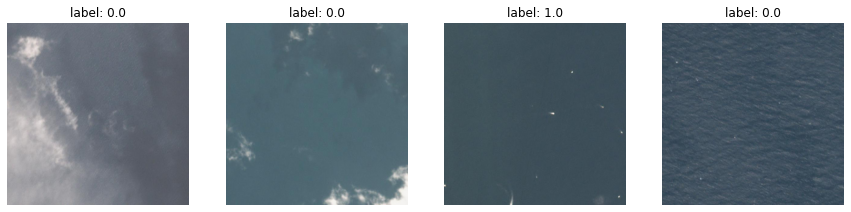

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf


images, labels = next(train_gen)

fig, axs = plt.subplots(1,4, figsize=(15,15))

for e,i in enumerate([0,7,16,31]):
  img_title = 'label: ' + str(labels[i])
  axs[e].imshow(images[i]), axs[e].axis('off'), axs[e].title.set_text(img_title)

plt.show()

# plt.figure(figsize=(10, 10))
# for i, (image, label) in enumerate(train_dataset.take(9)):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image)
#     plt.title(int(label))
#     plt.axis("off")

## Define Model

In [8]:
from tensorflow import keras

def build_model():
  base_model = keras.applications.InceptionResNetV2(
      weights="imagenet",  # Load weights pre-trained on ImageNet.
      input_shape=(img_width, img_height, 3),
      include_top=False,
  )  # Do not include the ImageNet classifier at the top.

  # Freeze the base_model
  base_model.trainable = False

  # Create new model on top
  inputs = keras.Input(shape=(img_width, img_height, 3))
  x = inputs
  #x = data_augmentation(inputs)  # Apply random data augmentation

  # Pre-trained Xception weights requires that input be scaled
  # from (0, 255) to a range of (-1., +1.), the rescaling layer
  # outputs: `(inputs * scale) + offset`
  #scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  #x = scale_layer(x)


  # The base model contains batchnorm layers. We want to keep them in inference mode
  # when we unfreeze the base model for fine-tuning, so we make sure that the
  # base_model is running in inference mode here.
  x = base_model(x, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(inputs, outputs)
  model.summary()
  
  return model
  

## Train the top layer only

In [ ]:
import keras.backend as K
from tensorflow.keras import metrics

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[metrics.BinaryAccuracy(), f1_m],
)

model.fit(train_gen, epochs=20, validation_data=validation_gen)

219070464/219055592 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 11, 11, 1536)     54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                            

## Unfreeze and fine tune the whole model

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
#base_model.trainable = True
model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), f1_m],
)

model.fit(train_gen, epochs=10, validation_data=validation_gen)

In [ ]:
# from sklearn.metrics import roc_curve, roc_auc_score, f1_score

# y_pred = model.predict(X_test).ravel()
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# auc = roc_auc_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred.round().astype(int), pos_label=1, average="binary")

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr, label='(area = {:.3f}, F1 = {:.3f})'.format(auc, f1))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()
# # Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr, label='(area = {:.3f}, F1 = {:.3f})'.format(auc, f1))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()